### Initialize

In [1]:
repump_power_405 = 0.1

In [2]:
from matplotlib import pyplot as plt
from matplotlib import ticker
import datetime
import os
import numpy as np


SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', family='Arial', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle='--')
plt.rc('grid', color='#E68F6B')
from ast import literal_eval as make_tuple
def get_param_from_file(file_name, name):
    range_ = ""
    with open(file_name, "r") as f:
        for line in f.readlines():
            if name in line:
                range_ = line
    return make_tuple(range_.strip().split("=")[-1])

def get_scan_range(file_name):
    return get_param_from_file(file_name, "scan range")

def get_confocal_scan_range(file_name):
    return  get_param_from_file(file_name, "x scan range"),  get_param_from_file(file_name, "y scan range")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

# define the Lorentzian function
def multiple_lorentzian(x, centers, sigmas, amplitudes):
    """ Mathematical definition of the sum of multiple (physical) Lorentzian functions without any
    bias.

    WARNING: iterable parameters "centers", "sigmas" and "amplitudes" must have same length.

    @param float x: The independent variable to calculate lorentz(x)
    @param iterable centers: Iterable containing center positions for all lorentzians
    @param iterable sigmas: Iterable containing sigmas for all lorentzians
    @param iterable amplitudes: Iterable containing amplitudes for all lorentzians
    """
    assert len(centers) == len(sigmas) == len(amplitudes)
    return sum(amp * sig ** 2 / ((x - c) ** 2 + sig ** 2) for c, sig, amp in
               zip(centers, sigmas, amplitudes))

def lorentzian(x, offset, center, sigma, amplitude):
    return offset + multiple_lorentzian(x, (center,), (sigma,), (amplitude,))

def double_lorentzian(x, offset, center_1, center_2, sigma_1, sigma_2, amplitude_1, amplitude_2):
    return offset + multiple_lorentzian(x,
                                        (center_1, center_2),
                                        (sigma_1, sigma_2),
                                        (amplitude_1, amplitude_2))

def multi_lorentzians(x, *params):
    num_lorentzians = len(params) // 3
    result = np.zeros_like(x)
    for i in range(num_lorentzians):
        center = params[i * 3]
        sigma = params[i * 3 + 1]
        amplitude = params[i * 3 + 2]
        result += lorentzian(x, center, sigma, amplitude)
    return result

# generate some sample data
xdata = np.linspace(-10, 10, 201)
ydata = lorentzian(xdata, 0, 0, 1, 1) + np.random.normal(0, 0.1, xdata.shape)

# define the model and set initial parameter values


In [4]:
#INITIALIZA THE FUNCTIONS 
#%%
#import the necessary packages
import automatization
from automatization.ple_statistics import PleAuto
import pandas as pd
import os
import time
import json
from importlib import reload
import numpy as np
from automatization.ple_statistics import PleAuto
from matplotlib import pyplot as plt
reload(automatization.ple_statistics)
from automatization.ple_statistics import PleAuto
from scipy.constants import speed_of_light
import pickle
from pathlib import Path

import sys

sys.setrecursionlimit(10000)

pa = PleAuto(
    ple_gui, 
    ple_optimize_logic, 
    laser_scanner_logic,
    poi_manager_logic, 
    scanning_optimize_logic,
    spectrometer,  
    
    spectrometerlogic,
    cobolt,
    ibeam_smart
)

# def ple_is_here(res, center_sigma = 3e3, amplitude = 1000, sigma_stderr_ratio = 4, amplitude_stderr_ratio=3):
#     """Check if the ple is still there."""
#     it_is = True
#     if res["center"].stderr is None or res["sigma"].stderr is None or res["sigma"].value is None:
#         return False
#     if ( res["center"].stderr > center_sigma or 
#     res["sigma"].stderr * sigma_stderr_ratio > res["sigma"].value or 
#     res["amplitude"].stderr * amplitude_stderr_ratio > res["amplitude"].value or
#     res["amplitude"].value < amplitude): 
#         #ple is gone.
#         return False

#     return it_is
def ple_is_here(rsquared_bound = 0.5):
    """Check if the ple is still there."""
    
    if ple_gui.fit_result[1].rsquared < rsquared_bound:
        print("NO, PLE", ple_gui.fit_result[1].rsquared )
        return False
    
    else:
        return True


def adjust_eta(pa, poi_name, folder_defect, results_poi, center_v):
    """Adjust the etalon voltage to get the best fit."""
    # ple_gui._osd.settings_widget.optimize_sequence_combobox.setCurrentIndex(seqs["a"])
    ple_gui._mw.frequencyDoubleSpinBox.setValue(1000)
    
    eta_volts = [center_v, center_v + 0.2, center_v + 0.4, center_v + 0.6, center_v - 0.2, center_v - 0.4,  center_v - 0.6]
    r_squared = []
    for eta_v in eta_volts:
        laser_controller_remote.etalon_voltage = eta_v
        time.sleep(0.5)
        res = pa.do_ple_scan(lines = 1)
        time.sleep(0.5)
        r_squared.append(ple_gui.fit_result[1].rsquared)
    results_poi["eta_voltage"] = eta_volts[r_squared.index(max(r_squared))]
    laser_controller_remote.etalon_voltage = eta_volts[r_squared.index(max(r_squared))]
    res = pa.do_ple_scan(lines = 1)
    pa.save_ple(tag = "full_range_eta_adjusted",
                poi_name=poi_name, folder_name=folder_defect)

    ple_gui._mw.frequencyDoubleSpinBox.setValue(250)
    return res, results_poi
def ple_refocus(pa, opt_times = 1, 
                scan_frequency=200, 
                scan_resolution=500,
                scan_range = 5000):
    
    seqs = {str(seq): idx for idx, seq in enumerate(ple_gui._osd.settings_widget.available_opt_sequences)}
    ple_gui._osd.settings_widget.optimize_sequence_combobox.setCurrentIndex(seqs["a"])
    ple_gui._osd.change_settings({'scan_frequency': {"a": scan_frequency},
                                    "scan_resolution": {"a":scan_resolution},
                                    "scan_range": {"a": scan_range}}) #GHz

    ple_gui._osd.accept()
    time.sleep(0.8)
    pa.optimize_ple()
    return res
def settings_confocal_refocus(sequence = "xy, z", scan_range_xy= 1e-6, scan_resolution = 25, scan_frequency = 25):
    seqs = {str(seq): idx for idx, seq in enumerate(scanner_gui._osd.settings_widget.available_opt_sequences)}
    scanner_gui._osd.settings_widget.optimize_sequence_combobox.setCurrentIndex(seqs[sequence])
    scanner_gui._osd.change_settings({'scan_frequency': {"x": scan_frequency, "y": scan_frequency, "z": scan_frequency},
                                    "scan_resolution": {"x": scan_resolution, "y": scan_resolution, "z":80},
                                    "scan_range": {"x": scan_range_xy, "y": scan_range_xy, "z": 4e-6}})

    scanner_gui._osd.accept()
    time.sleep(0.5)


def settings_confocal_refocus_coarse():
    seqs = {str(seq): idx for idx, seq in enumerate(scanner_gui._osd.settings_widget.available_opt_sequences)}
    scanner_gui._osd.settings_widget.optimize_sequence_combobox.setCurrentIndex(seqs["x, y, z"])

    scanner_gui._osd.change_settings({'scan_frequency': {"x": 5, "y": 5, "z": 5},
                                    "scan_resolution": {"x": 80, "y": 80, "z":80},
                                    "scan_range": {"x": 2.5e-6, "y": 2.5e-6, "z": 4.5e-6}})
    scanner_gui._osd.accept()
    time.sleep(0.5)

def confocal_refocus(opt_times=2):
    for i in range(opt_times):
        scanning_optimize_logic.start_optimize()
        while scanning_optimize_logic.module_state()=='locked':
            time.sleep(0.5)
    time.sleep(0.5)
#find the defect:
def find_the_defect(pa, poi_name, folder_defect):
    ple_gui._mw.frequencyDoubleSpinBox.setValue(1000)
    switchlogic.set_state("ScanningMode", 'Wavemeter')
    pa.set_resonant_power(power = 300)
    cobolt.enable_modulated()
    cobolt.set_laser_modulated_power(2)
    time.sleep(1)
    settings_confocal_refocus_coarse()
    confocal_refocus(opt_times=2)

    
    switchlogic.set_state("ScanningMode", 'NI')
    time.sleep(0.5)
    #Check how the PLE look like
    res = pa.do_ple_scan(lines = 1)

    #configure slow scanning for the wavemeter scanning optimizations
    for kk in range(3):
        if not ple_is_here():
            switchlogic.set_state("ScanningMode", 'Wavemeter')
            time.sleep(0.5)
            settings_confocal_refocus_coarse()
            confocal_refocus(opt_times=1)
            #Check how the PLE look like
            time.sleep(0.5)
            switchlogic.set_state("ScanningMode", 'NI')
            res = pa.do_ple_scan(lines = 1)
            time.sleep(0.5)
            pa.save_ple(tag = "full_range_iter_{kk}",
                    poi_name=poi_name, folder_name=folder_defect)
            time.sleep(0.5)
        else:
            break

    pa.save_ple(tag = "full_range",
            poi_name=poi_name, 
            folder_name=folder_defect)
    time.sleep(0.2)
    ple_gui._mw.frequencyDoubleSpinBox.setValue(250)
    return res

def take_spectrum(pa, poi_name, folder_defect):
    # take spectrum to estimate SOC
    pa.set_resonant_power(power = 0)
    
    ibeam_smart.setPower(60000)
    ibeam_smart.enable()
    
    cobolt.enable_modulated()
    cobolt.set_laser_modulated_power(power = 100)
    
    time.sleep(5)
    
    pa.take_spectrum()

    
    
    time.sleep(1)
    spectrometer._mw.data_widget.fit_widget.sigDoFit.emit("DoubleLorentzian")
    time.sleep(1)
    pa.save_spectrum(name_tag=f"{poi_name}_blueNgreen", folder_path=folder_defect)
    # spectrometer.fit_results.params["center_1"].value
    
    if spectrometer.fit_results is not None:
        params = spectrometer.fit_results.params
        soc_ghz = float(speed_of_light / params["center_2"].value - speed_of_light / params["center_1"].value)
        center_1_ghz = float(params["center_1"].value)
        center_2_ghz = float(params["center_2"].value)
    ibeam_smart.disable()
    ibeam_smart.setPower(3000)
    #cobolt.disable_modulated()
    time.sleep(0.1)
    # results_poi["spectrum_fit_data"] = spectrometer.fit_results.best_fit
    cobolt.enable_modulated()
    cobolt.set_laser_modulated_power(power = repump_power_405)
    pa.set_resonant_power(power = 300)    
    time.sleep(1)
    return soc_ghz, center_1_ghz, center_2_ghz
# Perform the saturation measurement

def fine_optimize(pa, poi_name, folder_defect, results_poi):
    res = pa.do_ple_scan(lines = 1)
    pa.go_to_ple_target(res["center"].value)
    ple_refocus(pa, scan_range=4000, scan_frequency=500)
    settings_confocal_refocus_fine()
    confocal_refocus(opt_times=1)
    ple_refocus(pa, scan_range=4000, scan_frequency=500)
    confocal_refocus(opt_times=1)
    res = pa.do_ple_scan(lines = 1)
    pa.go_to_ple_target(res["center"].value)
    results_poi["center"] = res["center"].value
    
    results_poi["center_λ"] = high_finesse_wavemeter_remote.get_current_wavelength()
    pa.save_ple(tag = "full_range_optimized",
            poi_name=poi_name, 
            folder_name=folder_defect)
    return res, results_poi

def run_saturation_measurement(pa, res, poi_name, folder_defect, results_poi, large_sigma = 4000, small_sigma = 300, power_steps = None, low_power_steps = None, repumped_power = 100, no_repump_power = 150):
    ple_gui._mw.frequencyDoubleSpinBox.setValue(500)

    os.makedirs(saturation_folder := os.path.join(folder_defect, "saturation"), exist_ok=True)
    results_poi["saturation"] = {}
    idx_no_ple = None
    res_old = res
    if power_steps is None:
        power_steps = 3 * np.logspace(1.5, 2, 10, endpoint=True).astype(int)[::-1]
    if low_power_steps is None:
        low_power_steps = np.array([85, 78, 70, 65, 60])
    power_steps = np.append(power_steps,low_power_steps)
    zero_range = (
                res["center"].value - large_sigma,
                res["center"].value + large_sigma
            )
    res = pa.do_ple_scan(lines = 1, in_range=zero_range)
    for idx, power in enumerate(power_steps):
        os.makedirs(power_folder := os.path.join(saturation_folder, f"{power}"), exist_ok=True)
        
        if power > repumped_power: 
            cobolt.enable_modulated()
            pa.set_resonant_power(power = power)
            time.sleep(1)
            #align twice
            # for i in range(2)
            
            fine_range = (
                res["center"].value - small_sigma,
                res["center"].value + small_sigma
            )
            if res["center"].value is None or res["sigma"].value is None or not ple_is_here(rsquared_bound=0.2):
                res = pa.do_ple_scan(lines = 1, in_range=zero_range)
                
                if not ple_is_here(rsquared_bound=0.2):
                    continue
            res = pa.do_ple_scan(lines = 1, in_range=fine_range)
            # if abs(res_old["center"].value - res["center"].value) > res_old["sigma"].value*2:
            #     res = res_old
            # else:s
            #     res_old = res
            pa.save_ple(tag = f"{power}",
                poi_name=poi_name, folder_name=power_folder)

            results_poi.update({"saturation": 
                            {f"{power}_repump":
                                {"scan_data": ple_data_logic.last_saved_files_paths,
                                "sigma": res["sigma"].value,
                                "sigma_stderr": res["sigma"].stderr,
                                "center": res["center"].value
                                }
                                }})
        if (power < no_repump_power):
            os.makedirs(power_folder_norepump := os.path.join(power_folder, f"no_repump"), exist_ok=True)
            # check with initioalization
            cobolt.disable_modulated()
            pa.one_pulse_repump("violet")
            for i in range(3):
                pa.one_pulse_repump("violet")
                res_ = pa.do_ple_scan(lines = 1, in_range=fine_range)
                if not ple_is_here(rsquared_bound=0.4):
                    continue
            if not ple_is_here(rsquared_bound=0.4):
                    continue
            res_ = pa.do_ple_scan(lines = 5, in_range=fine_range)
            print("Saving no repump")
            pa.save_ple(tag = f"{power}_norepump",
                poi_name=poi_name, folder_name=power_folder_norepump)
            results_poi.update({"saturation": 
                            {f"{power}_norepump":
                                {"scan_data": ple_data_logic.last_saved_files_paths,
                                "sigma": res_["sigma"].value,
                                "sigma_stderr": res_["sigma"].stderr,
                                "center": res_["center"].value
                                }
                                }})
        if power <= 40:
            break

            #save_plots
    return results_poi

def check_factor_sigma():
    # constraints
    scan_range_constr = laser_scanner_logic.scan_ranges["a"] 
    pa.go_to_ple_target(scan_range_constr[0])
    time.sleep(5)
    w1 = high_finesse_wavemeter_remote.get_current_wavelength()
    
    pa.go_to_ple_target(scan_range_constr[1])
    time.sleep(5)
    w2 = high_finesse_wavemeter_remote.get_current_wavelength()

    factor_sigma = (w2 - w1) * 1000000 / (scan_range_constr[1] - scan_range_constr[0]) #GHz 
    return factor_sigma

def get_optical_power(wavelength = 619):
    powermeter._set_wavelength(value=619)
    powermeter.set_activity_state(channel="Power", active=True)
    power = powermeter.get_process_value(channel="Power")
    return power * 1e9 # in nW

# constraints
scan_range_constr = laser_scanner_logic.scanner_constraints.axes["a"].value_range
scanning_optimize_logic._backwards_line_resolution = 20



import os

SCAN_RANGE = 1000
LARGE_SCAN_RANGE = 5000
c = 299792458

def setup_wavemeter_scan(repump_power):
    high_finesse_wavemeter_remote._wavemeter.set_regulation_mode(mode=True)
    switchlogic.set_state("ScanningMode", 'Wavemeter')
    cobolt.set_laser_modulated_power(repump_power)
    cobolt.enable_modulated()
    ibeam_smart.disable()
    pa.set_resonant_power(300)

def disable_wavemeter_scan():
    high_finesse_wavemeter_remote._wavemeter.set_regulation_mode(mode=False)
    switchlogic.set_state("ScanningMode", 'NI')

def create_directory(directory_name):
    os.makedirs(directory_name, exist_ok=True)
    return directory_name

def append_to_file(file_path, content):
    with open(file_path, "a") as f:
        f.write(content)

def find_ple_center():
    
    for i in range(3):
        res = pa.do_ple_scan(lines=1)
        if ple_is_here(rsquared_bound=0.15):
            pa.go_to_ple_target(res["center"].value)
            ple_refocus(pa, scan_range=4000, scan_frequency=500)
            res_center = laser_scanner_logic.scanner_target["a"]
            res = pa.do_ple_scan(lines=1, in_range=(res_center - LARGE_SCAN_RANGE, res_center + LARGE_SCAN_RANGE))
            if ple_is_here(rsquared_bound=0.6):
                break
        else:
            search_with_wavemeter_scan(opt_times=1)
    pa.go_to_ple_target(res["center"].value)
    ple_refocus(pa, scan_range=4000, scan_frequency=500)
    res_center = laser_scanner_logic.scanner_target["a"]
    return res_center

def search_with_wavemeter_scan(repump_power=0.2, opt_times=2):
    setup_wavemeter_scan(repump_power = repump_power)
    settings_confocal_refocus(sequence="x, y, z", scan_resolution=80, scan_frequency=5, scan_range_xy=3e-6)
    confocal_refocus(opt_times=opt_times)
    disable_wavemeter_scan()


def save_ple_data_and_optimize(poi_name, folder_defect, res_center):
    pa.save_ple(tag=f"ple_scan_{i}", poi_name=poi_name, folder_name=folder_defect)
    pa.go_to_ple_target(res_center)
    ple_refocus(pa, scan_range=4000, scan_frequency=500)

    wavelength = 1e-3 * c / high_finesse_wavemeter_remote.get_current_wavelength()
    append_to_file(os.path.join(folder_defect, "info.txt"), f"lambda = {wavelength} nm\n")

    #optimize in resonance
    cobolt.set_laser_modulated_power(5) #for optimization
    ple_refocus(pa, scan_range=LARGE_SCAN_RANGE, scan_frequency=500)
    settings_confocal_refocus(sequence="xy, z", scan_resolution=20, scan_frequency=100, scan_range_xy=1e-6)
    confocal_refocus(opt_times=1)
    ple_refocus(pa, scan_range=LARGE_SCAN_RANGE, scan_frequency=500)    
    settings_confocal_refocus(sequence="xy, z", scan_resolution=20, scan_frequency=100, scan_range_xy=1e-6)
    confocal_refocus(opt_times=1)
    cobolt.set_laser_modulated_power(repump_power_405)
    res = pa.do_ple_scan(lines = 1, in_range=(res_center - LARGE_SCAN_RANGE, res_center + LARGE_SCAN_RANGE))
    pa.go_to_ple_target(res["center"].value)
    ple_refocus(pa, scan_range=4000, scan_frequency=500)
    res_center = laser_scanner_logic.scanner_target["a"]

def perform_ple_measurements(poi_name, folder_defect, res_center):
    for power in [300, 250, 200, 180, 160]:
        power_folder = create_directory(os.path.join(folder_defect, f"{power}"))
        pa.set_resonant_power(power)
        cobolt.set_laser_modulated_power(repump_power_405)
        cobolt.enable_modulated()
        ibeam_smart.disable()

        pa.go_to_ple_target(res_center)
        ple_refocus(pa, scan_range=1000, scan_frequency=500)
        res_center_ = laser_scanner_logic.scanner_target["a"]

        res = pa.do_ple_scan(lines=1, in_range=(res_center_ - LARGE_SCAN_RANGE, res_center_ + LARGE_SCAN_RANGE))
        if not ple_is_here(rsquared_bound=0.2):
            res = pa.do_ple_scan(lines=1)
            if ple_is_here(rsquared_bound=0.4):
                pa.go_to_ple_target(res["center"].value)
                ple_refocus(pa, scan_range=3000, scan_frequency=500)
                res_center = laser_scanner_logic.scanner_target["a"]
            elif power > 200:
                break
        else:
            res_center = res_center_
        ple_params = f"\npower = {power}\n center = {res['center'].value}\n sigma = {res['sigma'].value}\n sigma_err = {res['sigma'].stderr}\nscan_range = {LARGE_SCAN_RANGE}\n violet repump\n\n"
        append_to_file(os.path.join(power_folder, f"ple_scan_power_{power}.txt"), ple_params)

        pa.save_ple(tag=f"power_{power}", poi_name=poi_name, folder_name=power_folder)

        res_ = pa.do_ple_scan(lines=1, in_range=(res_center - SCAN_RANGE, res_center + SCAN_RANGE))
        ple_params = f"\npower = {power}\n center = {res_['center'].value}\n sigma = {res_['sigma'].value}\n sigma_err = {res_['sigma'].stderr}\nscan_range = {SCAN_RANGE}\n violet repump\n\n"
        append_to_file(os.path.join(power_folder, f"ple_scan_power_{power}.txt"), ple_params)

        pa.save_ple(tag=f"power_{power}", poi_name=poi_name, folder_name=power_folder)


        if power <= 200:
            ple_gui._mw.frequencyDoubleSpinBox.setValue(350)
            ple_gui._mw.resolutionDoubleSpinBox.setValue(2000)

            # Prescan repump
            ple_gui._mw.Pulsed_widget.prescan_checkBox.setChecked(True)
            res = pa.do_ple_scan(lines=10, in_range=(res_center - SCAN_RANGE, res_center + SCAN_RANGE))
            pa.save_ple(tag=f"power_{power}_prescan_repump", poi_name=poi_name, folder_name=power_folder)

           
            ple_params = f"PRE_SCAN_REPUMP:\npower = {power}\n center = {res['center'].value}\n sigma = {res['sigma'].value}\n sigma_err = {res['sigma'].stderr}\nscan_range = {SCAN_RANGE}\n violet repump\n\n"
            with open(os.path.join(power_folder, f"ple_scan_power_{power}.txt"), "a") as f:
                f.write(ple_params)
            ple_rescan_here = ple_is_here(rsquared_bound=0.2)
            #no repump
            ple_gui._mw.Pulsed_widget.prescan_checkBox.setChecked(False)
            cobolt.disable_modulated()
            res = pa.do_ple_scan(lines = 10, in_range=(
                res_center - SCAN_RANGE, res_center + SCAN_RANGE))
            pa.save_ple(tag = f"power_{power}_NO_repump", 
                        poi_name=poi_name, folder_name=power_folder)
            ple_params = f"NO_REPUMP:\npower = {power}\n center = {res['center'].value}\n sigma = {res['sigma'].value}\n sigma_err = {res['sigma'].stderr}\nscan_range = {SCAN_RANGE}\n violet repump\n\n"
            with open(os.path.join(power_folder, f"ple_scan_power_{power}.txt"), "a") as f:
                f.write(ple_params)
            ple_norepump_here = ple_is_here(rsquared_bound=0.2)
            if not ple_norepump_here and not ple_rescan_here:
                break
            
    ple_gui._mw.Pulsed_widget.prescan_checkBox.setChecked(False)
    cobolt.enable_modulated()
    cobolt.set_laser_modulated_power(repump_power_405)
def run_450nm(on_off):
    seq = pulsestreamer.pulse_streamer.createSequence()
    # pulse_patt = [(100, 0), (200, 1), (80, 0), (300, 1), (60, 0)]

    seq.setDigital(2, [(100, int(on_off))])
    seq.setDigital(6, [(100, 1)])
    seq.setDigital(7, [(100, 1)])
    # Stream the continuous signal
    period = 1000  # Period in ns (1 us)
    n_runs = 0  # Number of runs (0 for continuous streaming)
    pulsestreamer.pulse_streamer.stream(seq)

def take_and_save_spectrum(poi_name, folder_defect):
    os.makedirs(spectrum_folder := os.path.join(folder_defect, f"spectrum"), exist_ok=True)
    
    soc_ghz, center_1_ghz, center_2_ghz = take_spectrum(pa, poi_name, spectrum_folder)

    line = f"\nsoc_ghz = {soc_ghz} GHz, \ncenter_1_ghz = {center_1_ghz} GHz, \ncenter_2_ghz = {center_2_ghz} GHz\n"
    with open(os.path.join(folder_defect, "info.txt"), "a") as f:
        f.write(line)


# New area

In [8]:
pa.one_pulse_repump(color="violet", power=0.01)

In [5]:
folder = r"Z:\Vlad\SnV\182\2R-1\07-05\auto"

## New defect initialization

In [50]:
poi_name = "def1"


os.makedirs(folder_defect := os.path.join(folder, poi_name),  exist_ok=True)

ple_gui._save_folderpath = folder_defect


ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

spectrometer._save_folderpath = folder_defect

spectrometer._mw.control_widget.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
spectrometer._mw.control_widget.save_path_widget.newPathCheckBox.setChecked(False)

### Wavemeter scanning mode

In [284]:
high_finesse_wavemeter_remote._wavemeter.set_regulation_mode(mode=True)
switchlogic.set_state("ScanningMode", 'Wavemeter')
cobolt.set_laser_modulated_power(repump_power_405)
cobolt.enable_modulated()
ibeam_smart.disable()
pa.set_resonant_power(300)


### Refocus confocal

In [282]:
settings_confocal_refocus(sequence="xy", scan_resolution=15, scan_frequency=75, scan_range_xy=1e-6)
confocal_refocus(opt_times=1)

settings_confocal_refocus(sequence="xy, z", scan_resolution=15, scan_frequency=75, scan_range_xy=1e-6)
confocal_refocus(opt_times=1)

In [195]:
settings_confocal_refocus(sequence="x, y, z", scan_resolution=80, scan_frequency=5)
confocal_refocus(opt_times=1)

### Switch to NI scanning

In [278]:
#Optimize the defect
high_finesse_wavemeter_remote._wavemeter.set_regulation_mode(mode=False)
switchlogic.set_state("ScanningMode", 'NI')
res = pa.do_ple_scan(lines = 1)



### Adjust eta

In [244]:
laser_controller_remote.etalon_voltage

-7.4

In [280]:
laser_controller_remote.etalon_voltage = -7.3

### Take spectra

In [42]:


soc_ghz, center_1_ghz, center_2_ghz = take_spectrum(pa, poi_name, folder_defect)

line = f"\nsoc_ghz = {soc_ghz} GHz, \ncenter_1_ghz = {center_1_ghz} GHz, \ncenter_2_ghz = {center_2_ghz} GHz\n"
with open(os.path.join(folder_defect, "info.txt"), "a") as f:
    f.write(line)


### Estimate sigma factor

In [40]:
factor_sigma = check_factor_sigma()
line = f"\nfactor_sigma = {factor_sigma}\n"
with open(os.path.join(folder_defect, "info.txt"), "a") as f:
    f.write(line)
print("Factor sigma", factor_sigma)

Factor sigma 1.0670191441665309


### Laser controls

In [234]:
pa.one_pulse_repump("violet")

In [204]:
cobolt.disable_modulated()

In [181]:
cobolt.enable_modulated()
cobolt.set_laser_modulated_power(1)

In [270]:
ibeam_smart.enable()

In [271]:
ibeam_smart.disable()

### Write wavelength

In [34]:
high_finesse_wavemeter_remote.start_acquisition()

0

In [36]:
dd = 1
w1 = high_finesse_wavemeter_remote.get_current_wavelength()
# buf = high_finesse_wavemeter_remote._wavelength_buffer
c = 299792458
print(1e-3 * c / w1, "nm")

line = f"postition {dd} lambda = {1e-3 * c / w1} nm\n"

with open(os.path.join(folder_defect, "info.txt"), "a") as f:
    f.write(line)
# np.savetxt(os.path.join(folder_defect, "wavelength_buffer.txt"), high_finesse_wavemeter_remote._wavelength_buffer)


619.243386201822 nm


### Write wavelength buffer

In [38]:
np.savetxt(os.path.join(folder, "WM_scan_wavelength_buffer.txt"), 
           high_finesse_wavemeter_remote._wavelength_buffer)


### Automated ple

In [45]:
SCAN_RANGE = 1000
for power in [300, 250, 200, 150, 120]:
    pa.set_resonant_power(power)
    res = pa.do_ple_scan(lines = 1, in_range=(
        res["center"].value - SCAN_RANGE, res["center"].value + SCAN_RANGE))
    
    line = f"\npower = {power}\n center = {res['center'].value}\n sigma = {res['sigma'].value}\n scan_range = SCAN_RANGE\n violet repump\n\n"
    with open(os.path.join(folder_defect, "ple_scans.txt"), "a") as f:
        f.write(line)
    pa.save_ple(tag = f"power_{power}", 
                poi_name=poi_name, folder_name=folder_defect)
    if not ple_is_here():
        print("Last power", power)
        last_power = power
        break


cobolt.disable_modulated()
for power in np.linspace(last_power, 100, 3, endpoint=True):
    pa.go_to_ple_target(res["center"].value)
    pa.set_resonant_power(power)
    pa.one_pulse_repump("violet", power=0.2)
    res = pa.do_ple_scan(lines = 1, in_range=(
        res["center"].value - SCAN_RANGE, res["center"].value + SCAN_RANGE))
    pa.save_ple(tag = f"power_{power}_norepump", 
                poi_name=poi_name, folder_name=folder_defect)
    
    line = f"\npower = {power}\n center = {res['center'].value}\n sigma = {res['sigma'].value}\n scan_range = SCAN_RANGE\n no violet repump\n\n"
    with open(os.path.join(folder_defect, "ple_scan_power_{power}.txt"), "a") as f:
        f.write(line)
    if not ple_is_here(rsquared_bound=0.05):
        print("Last power", power)
        break


NameError: name 'res' is not defined

In [129]:
cobolt.enable_modulated()
cobolt.set_laser_modulated_power(1)

In [128]:
laser_controller_remote.etalon_voltage =  -7.4

In [120]:
laser_controller_remote.etalon_voltage

-7.4

In [207]:
cobolt.disable_modulated()

In [220]:
cobolt.on_deactivate()

In [225]:
cobolt.enable_modulated()

In [224]:
cobolt.portOpen()

In [4]:
high_finesse_wavemeter_remote._wavemeter.get_reference_course(channel=2)

b'619.2360266 + 0.001 * sin(t)'

In [ ]:
high_finesse_wavemeter_remote._wavemeter.set_regulation_mode(mode=False)


# Automated

- [ ] Add power measurements
- [ ] Add info about repump to the save file
- [ ] Skip the defect if nothing found
- [ ] Adjust the polarization
- [ ] Measuring the g2
- [ ] Measuring the pulse to estimate T1

In [155]:
tagger.tagger.setConditionalFilter(trigger=[1, 2], filtered=[5])

In [161]:
motordriver_pi3.moveRelative(motor=0, pos=50)

In [136]:
polarization_counts = []
polarization_angles = np.linspace(0, 360, 19, endpoint=True)
pa.optimize_ple()
for angle in polarization_angles:
    motordriver_pi3.moveRelative(motor=0, pos=angle)
    time.sleep(1)
    pa.optimize_ple()
    time.sleep(0.2)
    counts = timetaggerlogic.counter.getData().mean(axis=0)[:-30].mean() * 100
    for i in range(3):
        pa.optimize_ple()
        time.sleep(0.2)
        counts += timetaggerlogic.counter.getData().mean(axis=0)[:-30].mean() * 100
    polarization_counts.append(counts / 4)

In [82]:
switchlogic.set_state("Excitation", 'On')
get_optical_power()

47037.9673

In [ ]:
repump_power_405 = 0.3

## Automation refactored

In [158]:
settings_confocal_refocus(sequence="xy, z", scan_resolution=20, scan_frequency=50)

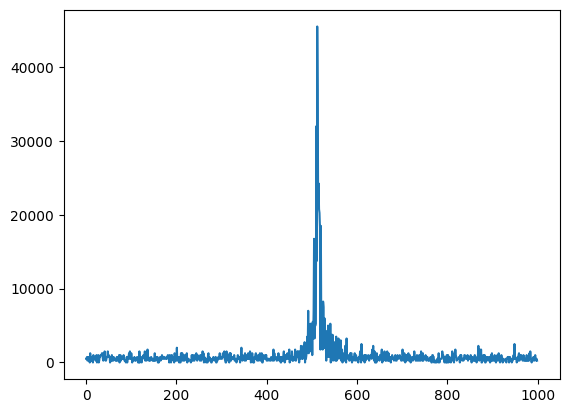

In [189]:
plt.plot([float(f) for f in ple_gui.scan_data.data["APD1"]])

In [242]:
cobolt.set_laser_modulated_power(0.1)

In [246]:
search_with_wavemeter_scan(repump_power=0.2)

In [ ]:
folder = r"Z:\Vlad\SnV\182\2R-1\09-05\auto_I"

In [255]:
poi_manager_logic.poi_names[19:]

['def20', 'def21', 'def22', 'def23', 'def24', 'def25', 'def26', 'def27', 'def28']

In [264]:
for poi_name in poi_manager_logic.poi_names[20:]:
    print("1. poi_name : ", poi_name)
    pa.go_to_poi(poi_name, ref_poi=None, opt_times=0)
    folder_defect = create_directory(os.path.join(folder, poi_name))

    os.makedirs(folder_defect := os.path.join(folder, poi_name),  exist_ok=True)

    ple_gui._save_folderpath = folder_defect


    ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
    ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

    spectrometer._save_folderpath = folder_defect

    spectrometer._mw.control_widget.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
    spectrometer._mw.control_widget.save_path_widget.newPathCheckBox.setChecked(False)

    print("2. Coarse search : ", folder_defect)
    search_with_wavemeter_scan()
    print("3. Fine search")
    res_center = find_ple_center()
    
    print("4. Save data and optimize around : ", res_center)
    save_ple_data_and_optimize(poi_name, folder_defect, res_center)

    factor_sigma = check_factor_sigma()
    append_to_file(os.path.join(folder_defect, "info.txt"), f"\nfactor_sigma = {factor_sigma}\n")

    print("5. Perform PLE measurements")
    perform_ple_measurements(poi_name, folder_defect, res_center)

    #take spectrum
    # print("6. Take spectrum")
    # take_and_save_spectrum(poi_name, folder_defect)

1. poi_name :  def21
2. Coarse search :  Z:\Vlad\SnV\182\2R-1\09-05\auto_I\def21
3. Fine search
4. Save data and optimize around :  12261.3944712316
5. Perform PLE measurements
NO, PLE -0.7101071166539363
NO, PLE 0.00018050904433175585
1. poi_name :  def22
2. Coarse search :  Z:\Vlad\SnV\182\2R-1\09-05\auto_I\def22
3. Fine search
4. Save data and optimize around :  14416.216292658
5. Perform PLE measurements
NO, PLE 0.0009230991272852762
1. poi_name :  def23
2. Coarse search :  Z:\Vlad\SnV\182\2R-1\09-05\auto_I\def23
3. Fine search
4. Save data and optimize around :  11258.1901237503
5. Perform PLE measurements
NO, PLE -0.27620591463959876
NO, PLE -0.352523735172777
NO, PLE -0.370548139074641
1. poi_name :  def24
2. Coarse search :  Z:\Vlad\SnV\182\2R-1\09-05\auto_I\def24
3. Fine search
4. Save data and optimize around :  11321.0149987044
5. Perform PLE measurements
NO, PLE -0.1385949786248566
NO, PLE -0.2341668788731328
1. poi_name :  def25
2. Coarse search :  Z:\Vlad\SnV\182\2R-1\09-

KeyboardInterrupt: 

# Manual

In [17]:
cobolt.enable_modulated()

In [18]:
cobolt.disable_modulated()

In [15]:
folder = "Z:\Vlad\SnV\TinGeneration\158-#1D\22-05" #r'Z:\Vlad\SnV\TinGeneration\158-#1C\defects'
high_finesse_wavemeter_remote.start_acquisition()

repump_power_405 = 0.2

cobolt.set_laser_modulated_power(0.01)
cobolt.enable_modulated()
ibeam_smart.disable()
# ibeam_smart.enable()
run_450nm(0)

NameError: name 'pulsestreamer' is not defined

In [9]:
setup_wavemeter_scan(repump_power=2)

In [10]:
ni_laser_scanner._update_position_ranges({"a": (0, 29999)})

In [6]:
disable_wavemeter_scan()

In [1]:


poi_name = "def_1"

# pa.go_to_poi(poi_name, ref_poi=None, opt_times=0)
folder_defect = create_directory(os.path.join(folder, poi_name))

os.makedirs(folder_defect := os.path.join(folder, poi_name),  exist_ok=True)

ple_gui._save_folderpath = folder_defect


ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

spectrometer._save_folderpath = folder_defect

spectrometer._mw.control_widget.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
spectrometer._mw.control_widget.save_path_widget.newPathCheckBox.setChecked(False)

# print("2. Coarse search : ", folder_defect)
# search_with_wavemeter_scan()
setup_wavemeter_scan(repump_power=0.5)
ple_gui.save_path_widget.saveTagLineEdit.setText(f"repump_405nm_{repump_power_405}")

NameError: name 'create_directory' is not defined

In [96]:

print("3. Fine search")
disable_wavemeter_scan()
res = pa.do_ple_scan(lines=1)
pa.go_to_ple_target(res["center"].value)
ple_refocus(pa, scan_range=4000, scan_frequency=500)
res_center = laser_scanner_logic.scanner_target["a"]

os.makedirs(folder_saturated := os.path.join(folder_defect, "saturated"),  exist_ok=True)
ple_gui._save_folderpath = folder_saturated
ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

pa.save_ple(tag=f"repump_405nm_{repump_power_405}_initial", 
            poi_name=poi_name, 
            folder_name=folder_saturated)


3. Fine search


In [89]:
#Optional
laser_controller_remote.etalon_voltage = -7.4
# motordriver_pi3.moveRelative(motor=3, pos=330)

In [13]:
ibeam_smart.enable()

In [107]:
wavelength = 1e-3 * c / high_finesse_wavemeter_remote.get_current_wavelength()
append_to_file(os.path.join(folder_defect, "info.txt"), f"lambda_optimized = {wavelength} nm\n")

In [108]:
run_450nm(False)

In [109]:
cobolt.enable_modulated()
cobolt.disable_modulated()
cobolt.enable_modulated()

In [110]:
cobolt.disable_modulated()

In [103]:
print("Repumped PLE")
power = 200
# power = 200 
# power = 150 
pa.set_resonant_power(power)
res_center = laser_scanner_logic.scanner_target["a"]
# res_center = res["center"].value
range_ = (res_center - SCAN_RANGE, res_center + SCAN_RANGE)
#res_center = laser_scanner_logic.scanner_target["a"]
#range_ = laser_scanner_logic.scan_ranges["a"]
res = pa.do_ple_scan(lines = 5, in_range=range_)
# pa.go_to_ple_target(res_center - SCAN_RANGE)

os.makedirs(folder_405_repumped := os.path.join(folder_defect, "405_repumped"),  exist_ok=True)
ple_gui._save_folderpath = folder_405_repumped
ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
ple_gui.save_path_widget.newPathCheckBox.setChecked(False)


pa.save_ple(tag=f"repump_405nm_{repump_power_405}_{power}", poi_name=poi_name, folder_name=folder_405_repumped)

Repumped PLE


In [92]:
repmp_power = 1
cobolt.set_laser_modulated_power(repmp_power)
run_450nm(0)

print("Prescan repumped")
power = 200
pa.set_resonant_power(power)
# power = 150 
# res_center = laser_scanner_logic.scanner_target["a"]
res_center = res["center"].value
range_ = (res_center - SCAN_RANGE/3, res_center + SCAN_RANGE/3)
range_ = laser_scanner_logic.scan_ranges["a"]
pa.set_resonant_power(power)
ple_gui._mw.Pulsed_widget.prescan_checkBox.setChecked(True)
res = pa.do_ple_scan(lines = 10, in_range=range_)
os.makedirs(folder_prerepumped := os.path.join(folder_defect, "prescan_repumped"),  exist_ok=True)
ple_gui._save_folderpath = folder_prerepumped
ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

pa.save_ple(tag=f"prescan_repump_405nm_{repmp_power}_{power}", poi_name=poi_name, folder_name=folder_prerepumped)

Prescan repumped


In [129]:
motordriver_pi3.moveRelative(motor=3, pos=0)

In [156]:
cobolt.disable_modulated()
run_450nm(1)

In [68]:
print("Not repumped")
power = 170

pa.one_pulse_repump("violet")
pa.set_resonant_power(power)

ple_gui._mw.Pulsed_widget.prescan_checkBox.setChecked(False)
cobolt.disable_modulated()
# res_center = laser_scanner_logic.scanner_target["a"]
res_center = res["center"].value
range_ = (res_center - SCAN_RANGE/3, res_center + SCAN_RANGE/3)
range_ = laser_scanner_logic.scan_ranges["a"]
res = pa.do_ple_scan(lines = 50, in_range=range_)
# pa.go_to_ple_target(res["center"].value)
# ple_refocus(pa, scan_range=1000, scan_frequency=500)
# res_center = laser_scanner_logic.scanner_target["a"]
os.makedirs(folder_no_rep := os.path.join(folder_defect, "no_repump"),  exist_ok=True)
ple_gui._save_folderpath = folder_no_rep
ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

pa.save_ple(tag=f"no_repump_{power}", poi_name=poi_name, folder_name=folder_no_rep)

Not repumped


In [111]:
os.makedirs(folder_no_rep := os.path.join(folder_defect, "no_repump"),  exist_ok=True)
ple_gui._save_folderpath = folder_no_rep
ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)

ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

In [207]:
run_450nm(on_off=True)

run_450nm(on_off=False)

In [105]:
print("CW 450 nm repumped")
power = 180
pa.set_resonant_power(power)
ple_gui._mw.Pulsed_widget.prescan_checkBox.setChecked(False)
cobolt.disable_modulated()
run_450nm(on_off=True)
# res_center = laser_scanner_logic.scanner_target["a"]
# range_ = (res_center - SCAN_RANGE/3, res_center + SCAN_RANGE/3)
range_ = laser_scanner_logic.scan_ranges["a"]
res = pa.do_ple_scan(lines = 10, in_range=range_)
# pa.go_to_ple_target(res["center"].value)
# ple_refocus(pa, scan_range=1000, scan_frequency=500)
# res_center = laser_scanner_logic.scanner_target["a"]
os.makedirs(folder_450_repumped := os.path.join(folder_defect, "450_repumped"),  exist_ok=True)
ple_gui._save_folderpath = folder_450_repumped
ple_gui.save_path_widget.currPathLabel.setText(ple_gui._save_folderpath)
ple_gui.save_path_widget.newPathCheckBox.setChecked(False)

pa.save_ple(tag=f"cw_repump_450nm_res_{power}", poi_name=poi_name, folder_name=folder_450_repumped)
run_450nm(on_off=False)

CW 450 nm repumped


In [69]:
factor_sigma = check_factor_sigma()
print(f"factor_sigma = {factor_sigma}")
append_to_file(os.path.join(folder_defect, "info.txt"), f"\nfactor_sigma = {factor_sigma}\n")\

np.savetxt(os.path.join(folder_defect, "wavelength_buffer.txt"), high_finesse_wavemeter_remote._wavelength_buffer)

factor_sigma = 1.1720788142582548


In [94]:
print("6. Take spectrum")
take_and_save_spectrum(poi_name, folder_defect)
#spectrometer._mw.control_widget.background_button.clicked.emit()# optional

6. Take spectrum


In [108]:
ibeam_smart.setPower(3000)
ibeam_smart.enable()

In [109]:
ibeam_smart.disable()

In [ ]:
# Maybe find defect with of resonant laser?

In [ ]:
#Optimize polarization
polarization_counts = []
polarization_angles = np.linspace(-45, 45, 20, endpoint=True)
motordriver_pi3.moveToAbsolutePosition(motor=0, pos=polarization_angles[0])
time.sleep(2)
for angle in polarization_angles:
    motordriver_pi3.moveToAbsolutePosition(motor=0, pos=angle)
    time.sleep(1)
    counts = timetaggerlogic.counter.getData().mean(axis=0)[:-30].mean() * 100
    for i in range(3):
        time.sleep(0.2)
        counts += timetaggerlogic.counter.getData().mean(axis=0)[:-30].mean() * 100
    polarization_counts.append(float(counts / 4))

motordriver_pi3.moveToAbsolutePosition(motor=0, 
                                       pos=polarization_angles[np.argmax(
                                           polarization_counts)])